In [1346]:
import sys
sys.path.append('../src')

In [1347]:
import pandas as pd
import numpy
from src.energiapy.components.temporal_scale import TemporalScale
from src.energiapy.components.resource import Resource, VaryingResource, Scope
from src.energiapy.components.process import Process, VaryingProcess
from src.energiapy.components.material import Material
from src.energiapy.components.location import Location
from src.energiapy.components.network import Network
from src.energiapy.components.scenario import Scenario
from src.energiapy.components.transport import Transport
from src.energiapy.model.formulate import formulate, Constraints, Objective
from src.energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from src.energiapy.plot import plot_results, plot_scenario
from src.energiapy.plot.plot_results import CostY, CostX
from src.energiapy.model.solve import solve
from itertools import product
from src.energiapy.components.result import Result
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from src.energiapy.model.solve import solve
from src.energiapy.plot.plot_results import CostY, CostX
from src.energiapy.components.location import Location
from src.energiapy.plot import plot_results, plot_scenario
from src.energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from src.energiapy.model.formulate import formulate, Constraints, Objective
from src.energiapy.model.bounds import CapacityBounds
from src.energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from src.energiapy.conversion.photovoltaic import solar_power_output
from src.energiapy.conversion.windmill import wind_power_output
from src.energiapy.model.constraints.integer_cuts import constraint_block_integer_cut, constraint_block_integer_cut_min

In [1348]:
# To solve the scheduling level problem for the motivating example of 3 forms of LNG production with varying GWP (resets every year), varying ERCOT power prices & NG prices (fluctuates every hour for the next 5 years)
# For optimal cost vs emission scenario (and varying weights for emission reduction , eg, for 10% reduction in emission, what is the best case scenario)

In [1349]:
horizon = 1
scales = TemporalScale(discretization_list=[1,24])

In [1350]:
bigM = 10**8
smallM = 0.001

In [1351]:
elec_price_df = pd.read_excel(r'C:\Users\saatvisuresh_1\Desktop\Saatvi Thesis\Complete_ERCOT_Prices_RepresentativeDay.xlsx')
elec_price_df.index


RangeIndex(start=0, stop=24, step=1)

In [1352]:
elec_price

np.float64(72.64)

In [1353]:
# Formula verified

#for index in elec_price_df.index:
    #if index <= 20:
        #GWP_value = 112.23
    #elif index <= 70:
        #GWP_value = 99.99
    #elif index <= 72:
        #GWP_value = 92.84
    #else:
        #GWP_value = 83.82
    
    #print(f"Index: {index}, GWP_value: {GWP_value}")  # To check the values dynamically


In [1354]:
for index in elec_price_df.index:
    if index <= 365:
        GWP_value = 112.23
    elif index >365 and index<= 730:
        GWP_value = ((99.99*(index - 365))+(112.23*365))/(index)
    elif index >730 and index<= 1095:
        GWP_value = ((92.84*(index - 730))+(99.99*365)+(112.23*365))/index
    elif index >1095 and index<= 1460:
        GWP_value = ((87.76*(index - 1095))+(99.99*365)+(112.23*365)+(92.84*730))/index
    else:
        GWP_value= (83.82*((index - 1460))+(87.76*365)+(99.99*365)+(112.23*365)+(92.84*730))/index
        # for 5 years

In [1355]:
# Fuel Mix GWP
GWP_df = pd.read_excel(r'C:\Users\saatvisuresh_1\Desktop\Saatvi Thesis\5 year_final\GWP_FuelMix_Day1.xlsx')
GWP_df.head()
GWP_df.index

RangeIndex(start=0, stop=24, step=1)

In [1356]:
# Outputs

CO2 = Resource(name='CO2 Vented from the process', basis='kg/hr',
               label='Carbon dioxide vented from the process', block='Resource', gwp = 1, sell=True, scope = Scope.ONE)

Methane = Resource(name='Methane leaked from the process', basis='kg/hr',
               label='Methane from the process', block='Resource', gwp = GWP_value, sell=True, scope = Scope.ONE)

NGL = Resource(name='Natural Gas Liquids_in_extraction', basis='kg/hr', label='Natural Gas Liquids_in_extraction', block='Resource', sell=True)

ProducedWater = Resource(name='H2O vented from the process',
               basis='kg/hr', sell=True, label='Water vented from the process', block='Resource')

LNG = Resource(name='LNG', demand = True, basis='kg/hr', label='LNG', block='Resource')

Boil_off_LNG = Resource(name='Boil_off_LNG', sell=True, basis='kg/hr', label='Boil_off_LNG', block='Resource')

Heat_Energy = Resource(name='Heat_Energy', basis='MW', label='Heat_Energy', sell=True, block='Resource')

#Methane = Resource(name='Methane leaked from the process', basis='kg/hr',
               #label='Methane from the process', block='Resource', gwp = GWP_value, varying = [VaryingResource.DETERMINISTIC_GWP], sell=True, scope = Scope.ONE)

# Inputs

Power = Resource(name='Power', basis='MW', label='Power generated')

GridPower = Resource(name='GridPower', basis='MW',
                     cons_max=bigM, label='Power bought', scope = Scope.TWO)
# Grid Power GWP from average value of time-varying GWP

ResourceWater = Resource(name='H2O',
               basis='kg/hr', cons_max=bigM, label='Water', price = 0.002, block='Resource')

Proppant_Additive = Resource(name='Proppant_Additive', basis='kg/hr', label='Proppant_Additive', block='Resource', price= 0.975, cons_max=bigM)
# Reference Link: https://www.maximizemarketresearch.com/market-report/global-proppant-market/14899/?utm_source=chatgpt.com

Diesel = Resource(name='Diesel', basis='kg/hr', label='Diesel', block='Resource', price= 0.98, cons_max=bigM)
# Reference Link: https://businessanalytiq.com/procurementanalytics/index/diesel-price-index/

Cooling_Water_In_Liquifaction = Resource(name='Cooling_Water_In_Liquifaction', basis='kg/hr', label='Cooling_Water_In_Liquifaction', block='Resource', cons_max=bigM, price= 0.0572)
# Reference link: https://www.intratec.us/products/industry-economics-worldwide/utility/cooling-water-united-states

LNG =  Resource(name='LNG', demand=True, basis='kg/hr', label='LNG', block='Resource')

Glycol = Resource(name='Glycol', basis='kg/hr', label='Glycol', block='Resource', cons_max=bigM, price= 0.052)
# Reference link: https://businessanalytiq.com/procurementanalytics/index/ethylene-glycol-price-index/

MDEA = Resource(name='MDEA', basis='kg/hr', label='MDEA', block='Resource', cons_max=bigM)

In [1357]:
print(elec_price_df.shape[0])

24


In [1358]:
# FU: 1 kg/hr of LNG
# 3 methane producing processes

Grid = Process(name='Grid', conversion={GridPower: -1, Power: 1}, prod_min=smallM, prod_max=bigM, label='Grid', basis='MW')

Conventional_NG = Process(name='Conventional_NG', conversion={Boil_off_LNG: 0.01, Power: -0.0028, ResourceWater: -0.5, Diesel: -0.000741382, Glycol: -0.000818111, MDEA: -0.012391658, Cooling_Water_In_Liquifaction: -1.75,
                                                              Methane: 0.00395, CO2: 0.966504505 , NGL: 0.3, Heat_Energy: 0.02, ProducedWater: 0.912, LNG: 1}, capex=0.17, fopex=1.5, vopex=1.5, prod_min=0.1, prod_max=bigM, label='Conventional LNG', basis='kg/hr')  

# https://shareholdersunite.com/the-ioc-files-useful-background-material/the-economics-of-lng/

ShaleGas = Process(name='ShaleGas', conversion={Boil_off_LNG: 0.01, Power: -0.003, ResourceWater: -0.92, Diesel: -0.002041766, Glycol: -0.01875, MDEA: -0.284, Cooling_Water_In_Liquifaction: -2.75,
                                                              Methane: 0.00895, CO2: 2.1, NGL: 1.9, Heat_Energy: 0.074, ProducedWater: 2.2205, LNG: 1}, capex=0.19, fopex=0.6, vopex=0.6, prod_min=0.1, prod_max=bigM, label='ShaleGas', basis='kg/hr')
# https://marcelluscoalition.org/wp-content/uploads/2012/07/The-Arithmetic-of-Shale-Gas.pdf

Coalbed = Process(name='Coalbed', conversion={Boil_off_LNG: 0.01, Power: -0.01, Diesel: -0.075, Glycol: -0.026539527, MDEA: -0.401985372, Cooling_Water_In_Liquifaction: -3.25,
                                                              Methane: 0.811, CO2: 5.823126126, NGL: 0.062761905, Heat_Energy: 0.002, ProducedWater: 6.2755, LNG: 1}, capex=0.205, fopex=2.24, vopex=1.17, prod_min=0.1, prod_max=bigM, label='CoalBed', basis='kg/hr')

# capacity needed? No

In [1359]:
process_set = {Grid, Conventional_NG, ShaleGas, Coalbed}

In [1360]:
# network scale level is 2, due to indexing issues. However, this shouldn't change the final output as capex is smallM. Fopex will be mentiond in hourly level
#{Methane:GWP_value, GridPower: GWP_df}

houston = Location(name='Houston', processes=process_set,  price_factor={GridPower: elec_price_df}, gwp_factor= {GridPower: GWP_df} , expenditure_scale_level=0,
                   scales=scales, label='Houston', demand_scale_level=0, price_scale_level=1, gwp_scale_level = 1)


In [1361]:

scenario = Scenario(name='scenario_full', network=houston, scales=scales,  demand_scale_level=0, expenditure_scale_level=0,
                    purchase_scale_level = 1, scheduling_scale_level=1, network_scale_level=0, gwp_scale_level = 1, 
                    label='full_case', demand={houston: {LNG:2000}})

In [1362]:
print("Contents of scenario.gwp_dict:", Location.gwp_factor)
#code not reading demand or gwp factor

Contents of scenario.gwp_dict: None


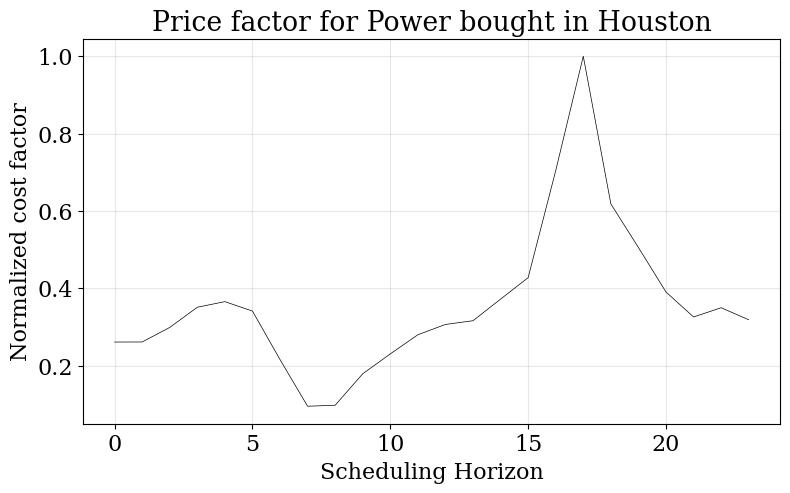

In [1363]:
plot_scenario.price_factor(scenario=scenario, location=houston, resource=GridPower, fig_size=(9, 5), color='black')

In [1364]:
#, Constraints.MODE

milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.NETWORK,
                      Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [1365]:
from pyomo.environ import ConstraintList

# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0, 0, 0):
        milp_cost.cons1.add(expr=milp_cost.P['Houston', 'Conventional_NG', *i] - milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05 * milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Constraint 2: Ramp down
milp_cost.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0, 0, 0):
        milp_cost.cons2.add(milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_cost.P['Houston', 'Conventional_NG', *i] <= 0.05 * milp_cost.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0, 0, 0):
        milp_cost.cons3.add(expr=milp_cost.P['Houston', 'ShaleGas', *i] - milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05 * milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Constraint 2: Ramp down
milp_cost.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0, 0, 0):
        milp_cost.cons4.add(milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_cost.P['Houston', 'ShaleGas', *i] <= 0.05 * milp_cost.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_cost.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0, 0, 0):
        milp_cost.cons5.add(expr=milp_cost.P['Houston', 'Coalbed', *i] - milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05 * milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Constraint 2: Ramp down
milp_cost.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0, 0, 0):
        milp_cost.cons6.add(milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_cost.P['Houston', 'Coalbed', *i] <= 0.05 * milp_cost.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])


In [1366]:
results_cost = solve(scenario=scenario, instance=milp_cost,
                     solver='gurobi', name=f"res_cost", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1695 rows, 8057 columns and 4400 nonzeros
Model fingerprint: 0xb741b34f
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1688 rows and 8048 columns
Presolve time: 0.00s
Presolved: 7 rows, 9 columns, 18 nonzeros
Variable types: 6 continuous, 3 integer (3 binary)
Found heuristic solution: objective 1590.4766947

Root relaxation: objective 1.590065e+03, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

In [1367]:
results_cost.output['objective']

1590.0651946933335

In [1368]:
results_cost.output['global_warming_potential_location']

{('Houston', 0): 6208.917}

In [1369]:
results_cost.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.0,
 ('Houston', 'Conventional_NG', 0): 0.0,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 83.33333333333333}

[83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333, 83.33333333333333]


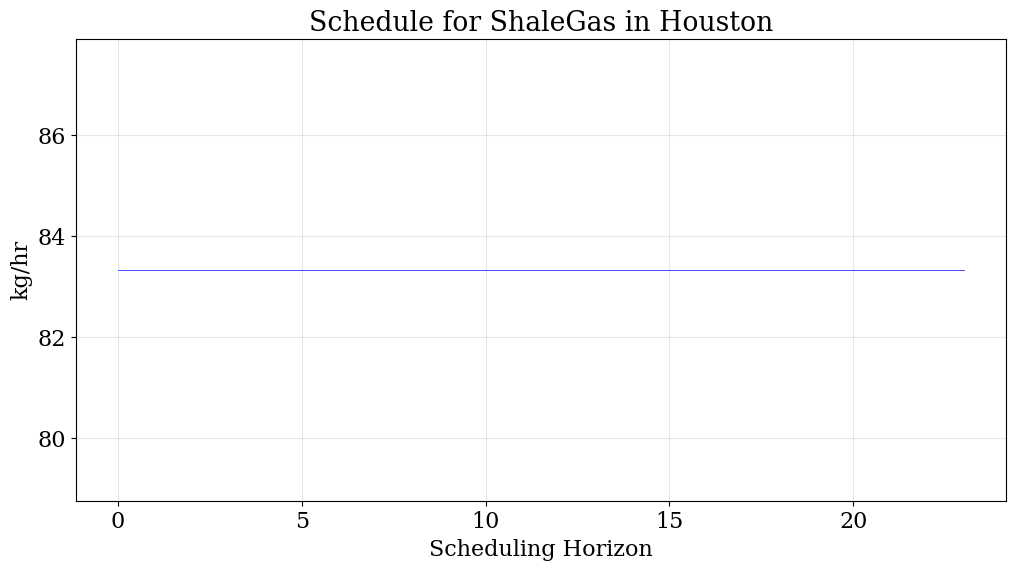

In [1370]:
plot_results.schedule(results = results_cost, y_axis= 'P', component = 'ShaleGas', location='Houston')

In [1371]:
data = results_cost.output['P']
df = pd.DataFrame(data,index=[0])
df = df.T
# Export the DataFrame to an Excel file
df.to_excel(r'C:\Users\saatvisuresh_1\Desktop\Saatvi Thesis\5 year_final\P_output_F_both_Cost_min.xlsx', index=True)

In [1372]:
#, Constraints.MODE

milp_gwp = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.MIN_GWP, demand_sign = 'eq')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint demand
constraint network cost
objective gwp min


In [1373]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons1.add(expr = milp_gwp.P['Houston', 'Conventional_NG', *i] - milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons2.add(milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons3.add(expr = milp_gwp.P['Houston', 'ShaleGas', *i] - milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons4.add(milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons5.add(expr = milp_gwp.P['Houston', 'Coalbed', *i] - milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp.cons6.add(milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])



In [1374]:
results_gwp = solve(scenario=scenario, instance=milp_gwp,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1692 rows, 8053 columns and 4399 nonzeros
Model fingerprint: 0xb42195a3
Coefficient statistics:
  Matrix range     [7e-04, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+08]
Presolve removed 1547 rows and 7981 columns
Presolve time: 0.01s
Presolved: 145 rows, 72 columns, 360 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8196260e+03   7.250000e+02   0.000000e+00      0s
      34    2.8196260e+03   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.819626010e+03

In [1375]:
results_gwp.output['objective']

2819.6260100000004

In [1376]:
results_gwp.output['Cost']

{None: 490503203.73819226}

In [1379]:
data = results_gwp.output['P']
df = pd.DataFrame(data,index=[0])
df = df.T
# Export the DataFrame to an Excel file
df.to_excel(r'C:\Users\saatvisuresh_1\Desktop\Saatvi Thesis\5 year_final\P_output_V_both_GWP_min.xlsx', index=True)

[74.22206154448413, 77.93316462170834, 81.82982285279377, 85.92131399543347, 90.21737969520514, 94.7282486799654, 99.46466111396367, 104.43789416966186, 102.24141686860003, 107.35348771203003, 101.98581332642853, 96.88652266010709, 92.04219652710174, 87.44008670074665, 83.06808236570932, 78.91467824742385, 74.96894433505265, 71.22049711830002, 67.65947226238501, 64.27649864926576, 61.062673716802465, 64.11580740264259, 67.32159777277472, 70.68767766141346]


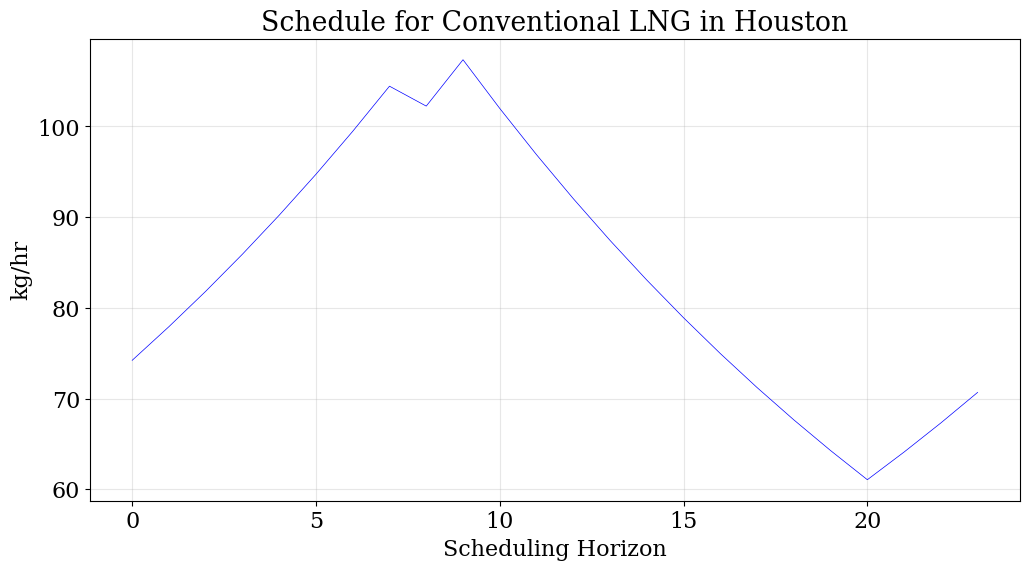

In [1381]:
plot_results.schedule(results = results_gwp, y_axis= 'P', component = 'Conventional_NG', location='Houston')

5% emission reduction

In [954]:
# Code 1
milp_gwp_5 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')
from src.energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_5, gwp_reduction_pct = 5, gwp = results_cost.output['global_warming_potential_network'][0])


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [955]:
# Code 3 
results_gwp_5 = solve(scenario=scenario, instance=milp_gwp_5,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1552 rows, 8057 columns and 4113 nonzeros
Model fingerprint: 0x404b9932
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1547 rows and 8051 columns
Presolve time: 0.01s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 1750.8629789

Root relaxation: objective 1.750618e+03, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

In [956]:
# Code 4
results_gwp_5.output['objective']

1750.6184788708817

In [957]:
# Code 5
results_gwp_5.output['global_warming_potential_location']

{('Houston', 0): 5898.47115}

In [959]:
# Code 6
results_gwp_5.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.0,
 ('Houston', 'Conventional_NG', 0): 7.633008666511699,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 75.70032466682163}

[7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699, 7.633008666511699]


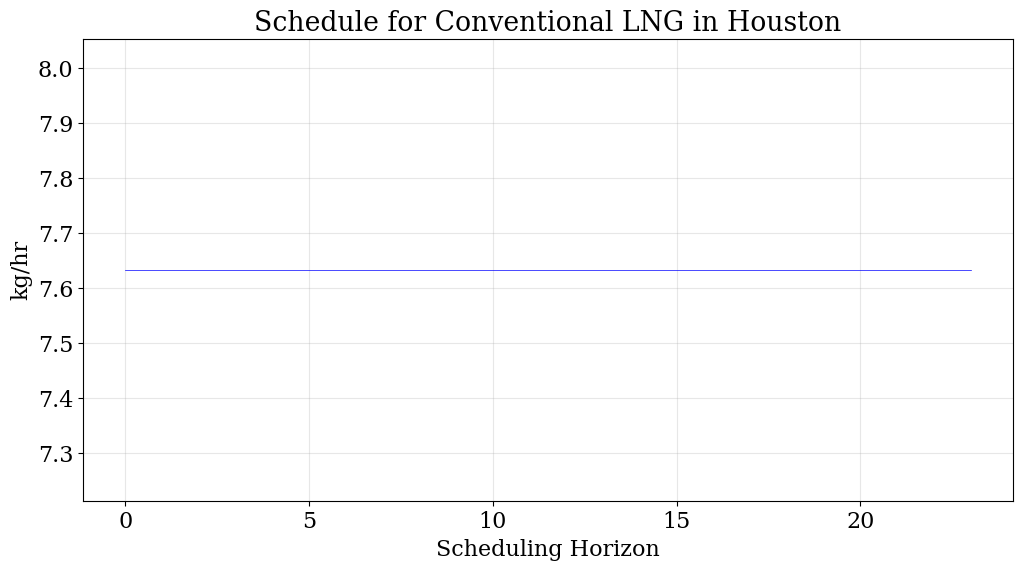

In [960]:
plot_results.schedule(results = results_gwp_5, y_axis= 'P', component = 'Conventional_NG', location='Houston')

[75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163, 75.70032466682163]


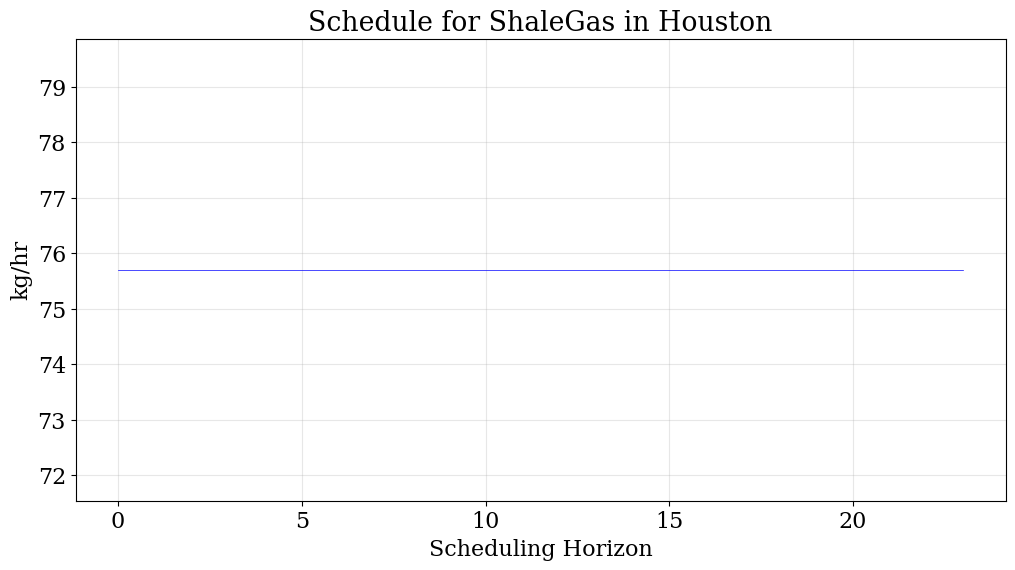

In [1164]:
plot_results.schedule(results = results_gwp_5, y_axis= 'P', component = 'ShaleGas', location='Houston')

Emission Restrictions by 10%

In [341]:
results_cost.output['global_warming_potential_network'][0]

8073.677426052885

In [342]:
milp_gwp_10 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from src.energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_10, gwp_reduction_pct = 10, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [343]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons1.add(expr = milp_gwp_10.P['Houston', 'Conventional_NG', *i] - milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons2.add(milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_10.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons3.add(expr = milp_gwp_10.P['Houston', 'ShaleGas', *i] - milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons4.add(milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_10.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_10.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons5.add(expr = milp_gwp_10.P['Houston', 'Coalbed', *i] - milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_10.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_10.cons6.add(milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_10.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_10.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [344]:
results_gwp_10 = solve(scenario=scenario, instance=milp_gwp_10,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0xc28bd7c4
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 2102.0867892

Root relaxation: objective 2.101842e+03, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

In [345]:
results_gwp_10.output['objective']

2101.8422891928576

In [346]:
results_gwp_10.output['global_warming_potential_location']

{('Houston', 0): 7266.309683447596}

In [347]:
results_gwp_10.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.0,
 ('Houston', 'Conventional_NG', 0): 19.148589848908188,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 64.18474348442516}

15% emission restrictions

In [348]:
# Code 1
milp_gwp_15 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_15, gwp_reduction_pct = 15, gwp = results_cost.output['global_warming_potential_network'][0])

# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_15.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_15.cons1.add(
            expr = milp_gwp_15.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_15.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_15.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_15.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_15.cons2.add(
            milp_gwp_15.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_15.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_15.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_15.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_15.cons3.add(
            expr = milp_gwp_15.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_15.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_15.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_15.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_15.cons4.add(
            milp_gwp_15.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_15.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_15.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_15.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_15.cons5.add(
            expr = milp_gwp_15.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_15.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_15.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_15.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_15.cons6.add(
            milp_gwp_15.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_15.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_15.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [349]:
# Code 3 
results_gwp_15 = solve(scenario=scenario, instance=milp_gwp_15,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0xc42736b3
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.01s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 2302.6253364

Root relaxation: objective 2.302381e+03, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

In [350]:
# Code 4
results_gwp_15.output['objective']

2302.380836442619

In [351]:
# Code 5
results_gwp_15.output['global_warming_potential_location']

{('Houston', 0): 6862.625812144952}

In [352]:
results_gwp_15.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.0,
 ('Houston', 'Conventional_NG', 0): 28.722884773362274,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 54.61044855997106}

20% Emission Restrictions

In [353]:
milp_gwp_20 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_20, gwp_reduction_pct = 20, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [354]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons1.add(expr = milp_gwp_20.P['Houston', 'Conventional_NG', *i] - milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons2.add(milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_20.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons3.add(expr = milp_gwp_20.P['Houston', 'ShaleGas', *i] - milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons4.add(milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_20.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_20.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons5.add(expr = milp_gwp_20.P['Houston', 'Coalbed', *i] - milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_20.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_20.cons6.add(milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_20.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_20.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])



In [355]:
results_gwp_20 = solve(scenario=scenario, instance=milp_gwp_20,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0x47c411fa
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 2503.1638837

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

In [356]:
results_gwp_20.output['objective']

2503.1638836923808

In [357]:
results_gwp_20.output['global_warming_potential_location']

{('Houston', 0): 6458.941940842308}

In [358]:
results_gwp_20.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 38.29717969781634,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 45.03615363551699}

25% emission reductions

In [359]:
#Code 1
milp_gwp_25 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_25, gwp_reduction_pct = 25, gwp = results_cost.output['global_warming_potential_network'][0])

# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_25.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_25.cons1.add(
            expr = milp_gwp_25.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_25.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_25.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_25.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_25.cons2.add(
            milp_gwp_25.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_25.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_25.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_25.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_25.cons3.add(
            expr = milp_gwp_25.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_25.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_25.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_25.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_25.cons4.add(
            milp_gwp_25.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_25.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_25.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_25.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_25.cons5.add(
            expr = milp_gwp_25.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_25.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_25.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_25.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_25.cons6.add(
            milp_gwp_25.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_25.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_25.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [360]:
# Code 3 
results_gwp_25 = solve(scenario=scenario, instance=milp_gwp_25,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0x3576165e
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 2703.7024309

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

In [361]:
# Code 4
results_gwp_25.output['objective']

2703.7024309421436

In [362]:
# Code 5
results_gwp_25.output['global_warming_potential_location']

{('Houston', 0): 6055.258069539664}

In [363]:
results_gwp_25.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 47.87147462227043,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 35.4618587110629}

30% emission restrictions

In [364]:
milp_gwp_30 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_30, gwp_reduction_pct = 30, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [365]:
# P is production rate
# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons1.add(expr = milp_gwp_30.P['Houston', 'Conventional_NG', *i] - milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons2.add(milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'Conventional_NG', *i] <= 0.05*milp_gwp_30.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons3.add(expr = milp_gwp_30.P['Houston', 'ShaleGas', *i] - milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons4.add(milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'ShaleGas', *i] <= 0.05*milp_gwp_30.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

# Similarly:
from pyomo.environ import ConstraintList

# Loop of how this code runs
# Constraint 1: except for the first value (year 1, day 1, hour 0), all the other values ramp up as per the previous production rate
milp_gwp_30.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons5.add(expr = milp_gwp_30.P['Houston', 'Coalbed', *i] - milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] <= 0.05* milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

#Constraint 2: Ramp down

milp_gwp_30.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_30.cons6.add(milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - milp_gwp_30.P['Houston', 'Coalbed', *i] <= 0.05*milp_gwp_30.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]])

In [366]:
results_gwp_30 = solve(scenario=scenario, instance=milp_gwp_30,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0xd7523eb2
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.01s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 2904.2409782

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

In [367]:
results_gwp_30.output['objective']

2904.240978191905

In [368]:
results_gwp_30.output['global_warming_potential_location']

{('Houston', 0): 5651.574198237019}

In [369]:
results_gwp_30.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 57.44576954672452,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 25.88756378660881}

35% emission constraint

In [370]:
# Code 1
milp_gwp_35 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_35, gwp_reduction_pct = 35, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [371]:
# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_35.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_35.cons1.add(
            expr = milp_gwp_35.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_35.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_35.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_35.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_35.cons2.add(
            milp_gwp_35.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_35.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_35.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_35.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_35.cons3.add(
            expr = milp_gwp_35.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_35.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_35.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_35.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_35.cons4.add(
            milp_gwp_35.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_35.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_35.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_35.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_35.cons5.add(
            expr = milp_gwp_35.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_35.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_35.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_35.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_35.cons6.add(
            milp_gwp_35.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_35.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_35.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )


In [372]:
# Code 3 
results_gwp_35 = solve(scenario=scenario, instance=milp_gwp_35,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0x66f3c1a0
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3104.7795254

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

[67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859, 67.02006447117859]


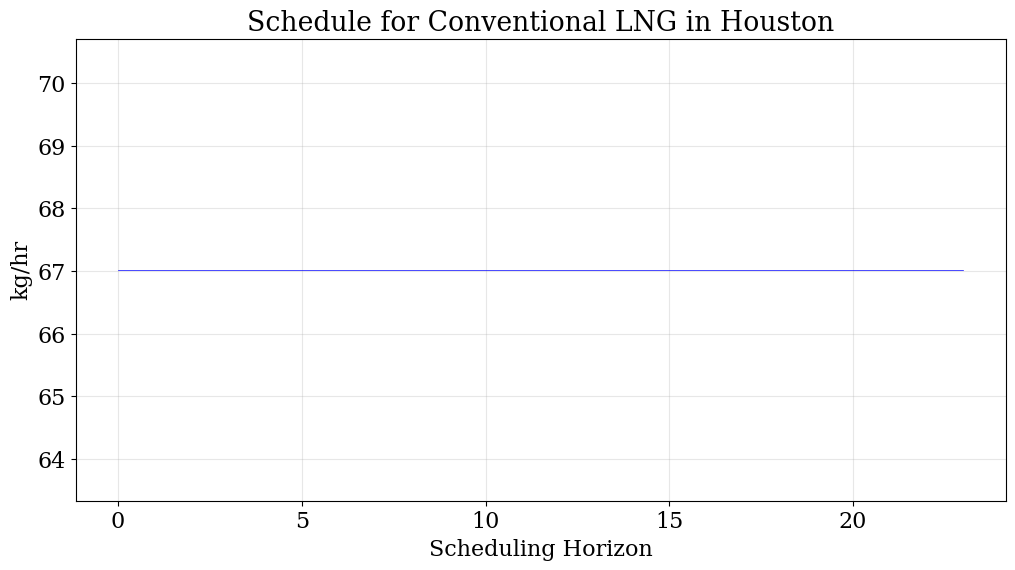

In [426]:
plot_results.schedule(results = results_gwp_35, y_axis= 'P', component = 'Conventional_NG', location='Houston')

In [421]:
# Code 4
results_gwp_35.output['objective']

3104.779525441666

In [375]:
# Code 5
results_gwp_35.output['global_warming_potential_location']

{('Houston', 0): 5247.8903269343755}

In [376]:
# Code 5
results_gwp_35.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 67.02006447117859,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 16.31326886215474}

37% Emission reduction

In [377]:
# Code 1
milp_gwp_37 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_37, gwp_reduction_pct = 37, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [378]:
# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_37.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_37.cons1.add(
            expr = milp_gwp_37.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_37.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_37.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_37.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_37.cons2.add(
            milp_gwp_37.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_37.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_37.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_37.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_37.cons3.add(
            expr = milp_gwp_37.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_37.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_37.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_37.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_37.cons4.add(
            milp_gwp_37.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_37.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_37.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_37.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_37.cons5.add(
            expr = milp_gwp_37.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_37.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_37.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_37.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_37.cons6.add(
            milp_gwp_37.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_37.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_37.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )


In [379]:
# Code 3 
results_gwp_37 = solve(scenario=scenario, instance=milp_gwp_37,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0xd2afd1a3
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3184.9949443

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

In [380]:
# Code 4
results_gwp_37.output['objective']


3184.994944341572

In [381]:
# Code 5
results_gwp_37.output['global_warming_potential_location']

{('Houston', 0): 5086.416778413317}

In [382]:
results_gwp_37.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 70.84978244096024,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 12.483550892373085}

38% emission reduction

In [383]:
# Code 1
milp_gwp_38 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_38, gwp_reduction_pct = 38, gwp = results_cost.output['global_warming_potential_network'][0])


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [384]:
# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_38.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_38.cons1.add(
            expr = milp_gwp_38.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_38.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_38.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_38.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_38.cons2.add(
            milp_gwp_38.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_38.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_38.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_38.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_38.cons3.add(
            expr = milp_gwp_38.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_38.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_38.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_38.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_38.cons4.add(
            milp_gwp_38.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_38.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_38.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_38.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_38.cons5.add(
            expr = milp_gwp_38.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_38.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_38.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_38.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_38.cons6.add(
            milp_gwp_38.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_38.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_38.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )


In [385]:
# Code 3 
results_gwp_38 = solve(scenario=scenario, instance=milp_gwp_38,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0x8e71402a
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3225.1026538

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

In [386]:
# Code 4
results_gwp_38.output['objective']

3225.1026537915254

In [387]:
# Code 5
results_gwp_38.output['global_warming_potential_location']

{('Houston', 0): 5005.680004152789}

In [388]:
# Code 6
results_gwp_38.output['Cap_P']


{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 72.76464142585105,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 10.568691907482279}

39% emission reduction

In [389]:
# Code 1
milp_gwp_39 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_39, gwp_reduction_pct = 39, gwp = results_cost.output['global_warming_potential_network'][0])


constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [390]:
# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_39.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_39.cons1.add(
            expr = milp_gwp_39.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_39.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_39.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_39.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_39.cons2.add(
            milp_gwp_39.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_39.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_39.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_39.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_39.cons3.add(
            expr = milp_gwp_39.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_39.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_39.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_39.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_39.cons4.add(
            milp_gwp_39.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_39.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_39.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_39.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_39.cons5.add(
            expr = milp_gwp_39.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_39.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_39.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_39.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_39.cons6.add(
            milp_gwp_39.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_39.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_39.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )


In [391]:
# Code 3 
results_gwp_39 = solve(scenario=scenario, instance=milp_gwp_39,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0x0ff19dbb
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.01s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3265.2103632

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

In [392]:
# Code 4
results_gwp_39.output['objective']


3265.210363241477

In [393]:
# Code 5
results_gwp_39.output['global_warming_potential_location']


{('Houston', 0): 4924.943229892259}

In [394]:
# Code 6
results_gwp_39.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 74.67950041074188,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 8.653832922591453}

40% emission reduction

In [395]:
# Code 1
milp_gwp_40 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_40, gwp_reduction_pct = 40, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [396]:
# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_40.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons1.add(
            expr = milp_gwp_40.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_40.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons2.add(
            milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_40.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_40.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_40.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons3.add(
            expr = milp_gwp_40.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_40.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons4.add(
            milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_40.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_40.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_40.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons5.add(
            expr = milp_gwp_40.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_40.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_40.cons6.add(
            milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_40.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_40.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )


In [397]:
# Code 3 
results_gwp_40 = solve(scenario=scenario, instance=milp_gwp_40,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0xe48f86af
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3305.3180727

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.00 seconds (0.0

In [398]:
# Code 4
results_gwp_40.output['objective']

3305.318072691428

In [399]:
# Code 5
results_gwp_40.output['global_warming_potential_location']

{('Houston', 0): 4844.206455631731}

In [400]:
# Code 6
results_gwp_40.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 76.59435939563268,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 6.7389739377006475}

41% emission reduction

In [401]:
# Code 1
milp_gwp_41 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_41, gwp_reduction_pct = 41, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [402]:
# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_41.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_41.cons1.add(
            expr = milp_gwp_41.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_41.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_41.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_41.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_41.cons2.add(
            milp_gwp_41.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_41.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_41.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_41.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_41.cons3.add(
            expr = milp_gwp_41.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_41.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_41.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_41.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_41.cons4.add(
            milp_gwp_41.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_41.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_41.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_41.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_41.cons5.add(
            expr = milp_gwp_41.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_41.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_41.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_41.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_41.cons6.add(
            milp_gwp_41.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_41.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_41.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

In [403]:
# Code 3 
results_gwp_41 = solve(scenario=scenario, instance=milp_gwp_41,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')


Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0x0aec3c31
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3345.4257821

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.00 seconds (0.0

In [404]:
results_gwp_41.output['objective']

3345.4257821413817

In [405]:
# Code 5
results_gwp_41.output['global_warming_potential_location']

{('Houston', 0): 4763.469681371203}

In [406]:
# Code 6
results_gwp_41.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 78.50921838052349,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 4.824114952809842}

42% emission reduction

In [407]:
# Code 1
milp_gwp_42 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_42, gwp_reduction_pct = 42, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [408]:
# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_42.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_42.cons1.add(
            expr = milp_gwp_42.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_42.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_42.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_42.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_42.cons2.add(
            milp_gwp_42.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_42.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_42.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_42.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_42.cons3.add(
            expr = milp_gwp_42.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_42.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_42.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_42.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_42.cons4.add(
            milp_gwp_42.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_42.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_42.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_42.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_42.cons5.add(
            expr = milp_gwp_42.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_42.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_42.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_42.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_42.cons6.add(
            milp_gwp_42.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_42.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_42.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

In [409]:
# Code 3 
results_gwp_42 = solve(scenario=scenario, instance=milp_gwp_42,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0x56450b30
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.01s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3385.5334916

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

In [410]:
# Code 4
results_gwp_42.output['objective']

3385.5334915913336

In [411]:
# Code 5
results_gwp_42.output['global_warming_potential_location']

{('Houston', 0): 4682.732907110673}

In [412]:
# Code 6
results_gwp_42.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 80.42407736541432,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 2.9092559679190155}

43% emission reduction

In [413]:
# Code 1
milp_gwp_43 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint_global_warming_potential_network_reduction(instance= milp_gwp_43, gwp_reduction_pct = 43, gwp = results_cost.output['global_warming_potential_network'][0])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost
constraint global warming potential network reduction


In [414]:
# Code 2
from pyomo.environ import ConstraintList

# Constraint 1: Ramp-up for Conventional_NG
milp_gwp_43.cons1 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_43.cons1.add(
            expr = milp_gwp_43.P['Houston', 'Conventional_NG', *i] - 
                   milp_gwp_43.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_43.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 2: Ramp-down for Conventional_NG
milp_gwp_43.cons2 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_43.cons2.add(
            milp_gwp_43.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_43.P['Houston', 'Conventional_NG', *i] 
            <= 0.05 * milp_gwp_43.P['Houston', 'Conventional_NG', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 3: Ramp-up for ShaleGas
milp_gwp_43.cons3 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_43.cons3.add(
            expr = milp_gwp_43.P['Houston', 'ShaleGas', *i] - 
                   milp_gwp_43.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_43.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 4: Ramp-down for ShaleGas
milp_gwp_43.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_43.cons4.add(
            milp_gwp_43.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_43.P['Houston', 'ShaleGas', *i] 
            <= 0.05 * milp_gwp_43.P['Houston', 'ShaleGas', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 5: Ramp-up for Coalbed
milp_gwp_43.cons5 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_43.cons5.add(
            expr = milp_gwp_43.P['Houston', 'Coalbed', *i] - 
                   milp_gwp_43.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] 
                   <= 0.05 * milp_gwp_43.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )

# Constraint 6: Ramp-down for Coalbed
milp_gwp_43.cons6 = ConstraintList()
for i in scales.scale_iter(2):
    if i != (0,0,0):
        milp_gwp_43.cons6.add(
            milp_gwp_43.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]] - 
            milp_gwp_43.P['Houston', 'Coalbed', *i] 
            <= 0.05 * milp_gwp_43.P['Houston', 'Coalbed', *scales.scale_iter(2)[scales.scale_iter(2).index(i) - 1]]
        )


In [415]:
# Code 3 
results_gwp_43 = solve(scenario=scenario, instance=milp_gwp_43,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Non-default parameters:
QCPDual  1

Optimize a model with 1696 rows, 8057 columns and 4449 nonzeros
Model fingerprint: 0x5d99144e
Variable types: 8053 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [7e-04, 1e+08]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+03, 1e+08]
Presolve removed 1691 rows and 8051 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)
Found heuristic solution: objective 3425.6412010

Root relaxation: interrupted, 0 iterations, 0.00 seconds (0.00 work units)

Explored 1 nodes (0 simplex iterations) in 0.01 seconds (0.0

In [416]:
# Code 4
results_gwp_43.output['objective']

3425.641201041286

In [417]:
# Code 5
results_gwp_43.output['global_warming_potential_location']

{('Houston', 0): 4601.996132850145}

In [418]:
# Code 6
results_gwp_43.output['Cap_P']

{('Houston', 'Coalbed', 0): 0.1,
 ('Houston', 'Conventional_NG', 0): 82.33893635030512,
 ('Houston', 'Grid', 0): 100000000.0,
 ('Houston', 'ShaleGas', 0): 0.9943969830282102}